In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout,LeakyReLU, ELU, Flatten, AveragePooling2D, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.python.client import device_lib

print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_built_with_cuda() 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8937475947267847077
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1764722688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1854622168121272136
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


True

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
def data_augmentation(x,y):
    
    # block is defined to find the size of the block to noise
    
    x_noise = x + np.random.normal(0.0, 0.5, x[:,:].shape)
    
    total_x = np.vstack((x, x_noise))
    total_y = np.vstack((y, y))
    print('the size of the total x:',total_x.shape)
    print('the size of the total y:',total_y.shape)
    
    
    return total_x,total_y

3


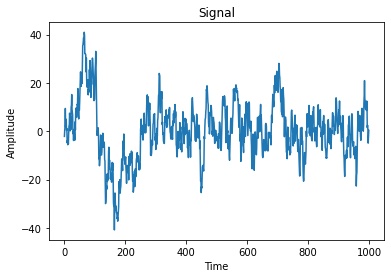

3


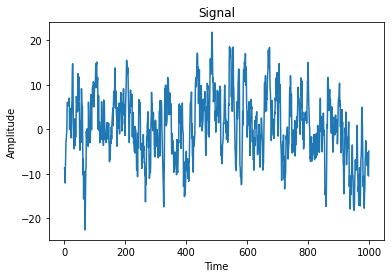

In [5]:
x_train = X_train_valid.reshape(2115, 22, 1000)
y_train = to_categorical((y_train_valid - 769), 4)

# x_train, y_train = data_augmentation(x_train,y_train)

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(1000), x_train[1,5,:], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# generate a random permutation of indices
perm = np.random.permutation(len(x_train))

# shuffle the training data and labels using the permutation
x_train = x_train[perm]
y_train = y_train[perm]


fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(1000), x_train[1,5,:], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# x_valid = x_train[3701:4229,:,:]
# y_valid = y_train[3701:4229,:]

# x_train = x_train[0:3700,:,:]
# y_train = y_train[0:3700,:]

x_valid = x_train[1701:2114,:,:]
y_valid = y_train[1701:2114,:]

x_train = x_train[0:1700,:,:]
y_train = y_train[0:1700,:]

x_test = X_test.reshape(443, 22, 1000)
y_test = to_categorical((y_test - 769), 4)

In [6]:
# Define an input layer for grayscale image
inputs = keras.Input(shape=(22,1000), name="EEG")

x = tf.keras.layers.Permute((2,1), name = 'permute-0')(inputs)

# Addign a bidirectional LSTM
# forward_layer = keras.layers.LSTM(32, return_sequences=True)
# backward_layer = keras.layers.LSTM(32, activation='leaky_relu', dropout=0.99, return_sequences=True, go_backwards=True)

x = keras.layers.Bidirectional(LSTM(32, input_shape=(1000, 22), return_sequences=True, kernel_regularizer=L1L2(0,0.01), 
                      recurrent_regularizer=L1L2(0,0.01), name="LSTM-1"))(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-1')(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.2, name = 'Dropout-1')(x)


# Adding a flattening operation 
x = keras.layers.Flatten()(x) 

x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-3-1')(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.1, name = 'Dropout-3-1')(x)

x = keras.layers.Dense(100)(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-4-1')(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.3, name = 'Dropout-4-1')(x)

# Output layer with Softmax activation 
class_probs = keras.layers.Dense(4, kernel_regularizer=L1L2(l1 = 0, l2 = 0.01), activation='softmax')(x) # Output FC layer with softmax activation

# now wrap the model inputs and outputs
model = keras.Model(inputs=inputs, outputs=class_probs, name="eeg_resnet")

model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8), metrics=[keras.metrics.categorical_accuracy])
    

# Printing the model summary
model.summary()

Model: "eeg_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EEG (InputLayer)            [(None, 22, 1000)]        0         
                                                                 
 permute-0 (Permute)         (None, 1000, 22)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 64)         14080     
 l)                                                              
                                                                 
 BN-1 (BatchNormalization)   (None, 1000, 64)          256       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 64)          0         
                                                                 
 Dropout-1 (Dropout)         (None, 1000, 64)          0         
                                                        

In [7]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime
from keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.optimizers import Adam

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 3, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# Model parameters
lr =5e-6
epochs = 50
opt = Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = model.fit(x_train,
             y_train,
             batch_size=20,
             epochs=epochs,
             callbacks=[tb_callback, lr_callback],                    
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
85/85 [==============================] - 25s 200ms/step - loss: 3.2697 - accuracy: 0.2388 - val_loss: 2.8893 - val_accuracy: 0.2833 - lr: 5.0000e-06
Epoch 2/50
85/85 [==============================] - 15s 180ms/step - loss: 3.0151 - accuracy: 0.3276 - val_loss: 2.8717 - val_accuracy: 0.3293 - lr: 5.0000e-06
Epoch 3/50
85/85 [==============================] - 14s 165ms/step - loss: 2.8308 - accuracy: 0.4082 - val_loss: 2.8612 - val_accuracy: 0.3632 - lr: 5.0000e-06
Epoch 4/50
85/85 [==============================] - 15s 171ms/step - loss: 2.7452 - accuracy: 0.4406 - val_loss: 2.8517 - val_accuracy: 0.3608 - lr: 5.0000e-06
Epoch 5/50
85/85 [==============================] - 14s 165ms/step - loss: 2.5915 - accuracy: 0.5241 - val_loss: 2.8388 - val_accuracy: 0.3826 - lr: 5.0000e-06
Epoch 6/50
85/85 [==============================] - 14s 159ms/step - loss: 2.4950 - accuracy: 0.5700 - val_loss: 2.8300 - val_accuracy: 0.3801 - lr: 5.0000e-06
Epoch 7/50
85/85 [======================

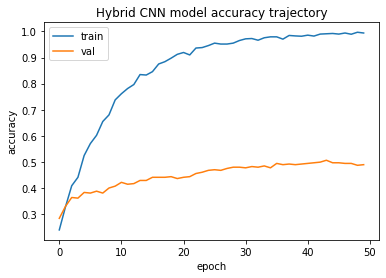

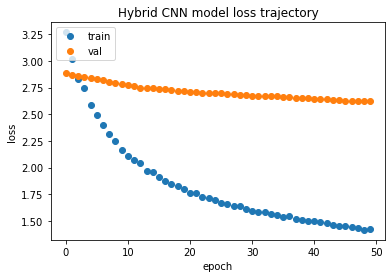

In [8]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.46049660444259644
